In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [4]:
train_data = datasets.FashionMNIST(root="data",
                                  train = True,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None)

test_data=datasets.FashionMNIST(root="data",
                               train=False,
                               download=True,
                               transform=ToTensor(),
                               target_transform=None)

100%|██████████| 26421880/26421880 [00:01<00:00, 13717184.84it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301809.18it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5453890.56it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10113478.68it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
image,label = train_data[0]
image,label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
image.shape,label

(torch.Size([1, 28, 28]), 9)

Text(0.5, 1.0, '9')

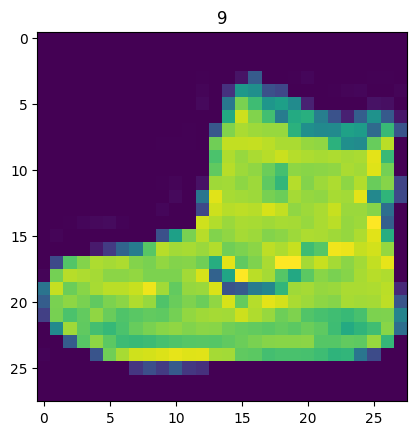

In [10]:
image.lable = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

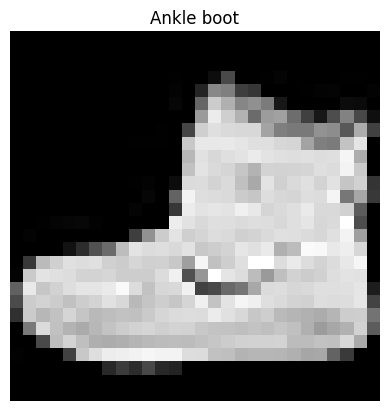

In [11]:
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False)

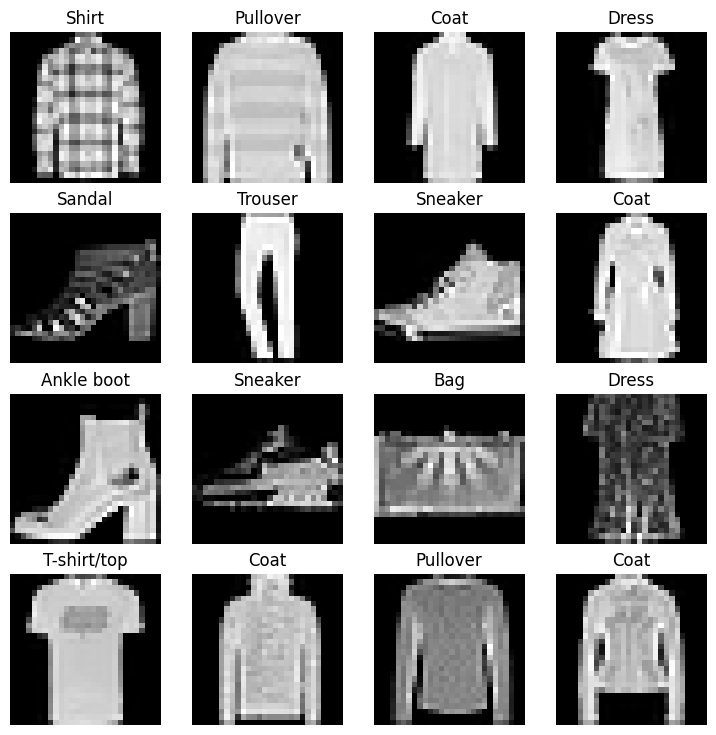

In [12]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    image,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [13]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7853207262f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7853207dc970>)

In [15]:
print(f"Dataloaders: {train_dataloader,test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7853207262f0>, <torch.utils.data.dataloader.DataLoader object at 0x7853207dc970>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [16]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size:torch.Size([1, 28, 28])
Label: 5,label size:torch.Size([])


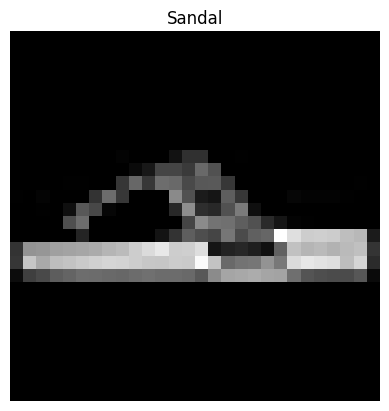

In [17]:
# torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size:{img.shape}")
print(f"Label: {label},label size:{label.shape}")


In [18]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening : {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening : torch.Size([1, 784])


In [19]:
output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.4078, 0.4078, 0.0000, 0.0000, 0.0000, 0.0353, 0.5961, 0.2000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3961, 0.9137, 0.9882, 0.9961, 1.0000, 0.9608, 0.9216, 1.0000, 1.0000,
         0.9843, 0.9373, 0.0353, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0196, 0.9608, 0.9882, 0.9412, 0.9569, 0.9647, 0.9882, 0.9843, 0.9725,
         0.9529, 0.9451, 1.0000, 0.8549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2471, 1.0000, 0.9569, 0.9608, 0.9608, 0.9569, 0.9490, 0.9490,
         0.9490, 0.9608, 0.9608, 0.9804, 0.9059, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [20]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=input_shape,out_features=hidden_units),
                                        nn.Linear(in_features=hidden_units,out_features=output_shape))
        
    def forward(self,x):
        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,
                             hidden_units=10,
                              output_shape = len(class_names)).to("cpu")
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [22]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [23]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [25]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    
    return acc

In [26]:
from timeit import default_timer as timer

def print_train_time(start: float,end: float,device: torch.device=None):
    
    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [27]:
start_time = timer()
end_time = timer()
print_train_time(start = start_time,end = end_time,device="cpu")

Train time on cpu: 0.000 seconds


2.6491999960853718e-05

In [28]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    train_loss = 0
    for batch,(X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred,y)
        train_loss+=loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if batch%400==0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")
        
    train_loss /= len(train_dataloader)
    
    test_loss,test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            
            test_pred = model_0(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)
            
            test_acc+=accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))
            
        test_loss/=len(test_dataloader)
        
        test_acc/=len(test_dataloader)
        
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc:{test_acc:.4f}%")

train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))
    
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc:82.0387%
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc:83.1969%
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc:83.4265%
Train time on cpu: 30.739 seconds


In [29]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn):
    
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            y_pred = model(X)
            
            loss+=loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
            
        loss/=len(data_loader)
        acc/=len(data_loader)
        
        
    return {"model_name":model.__class__.__name__,
           "model_loss":loss.item(),
           "model_acc":acc}

model_0_results = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [30]:
torch.cuda.is_available()

True

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
class FashionMNISTV1(nn.Module):
    def __init__(self,input_shape:int,
                hidden_units:int,
                output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=input_shape,
                                                 out_features=hidden_units),
                                        nn.ReLU(),
                                        nn.Linear(in_features=hidden_units,
                                                 out_features=output_shape),
                                        nn.ReLU())
        
        
    def forward(self,x: torch.Tensor):
        return self.layer_stack(x)    

In [33]:
torch.manual_seed(42)
model1 = FashionMNISTV1(input_shape=784,
                       hidden_units=10,
                       output_shape=len(class_names)).to(device)
model1

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [35]:
next(model1.parameters()).to(device)

Parameter containing:
tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
       device='cuda:0', requires_grad=True)

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)

In [44]:
def train_step(model:nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device = device):
    train_loss,train_acc=0,0
    model.train()

    train_loss = 0
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss+=loss
        train_acc+=accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
    train_loss /= len(data_loader)
    train_acc/=len(data_loader)
    print(f"Train loss:{train_loss:.5f} | Train acc:{train_acc:.2f}%")

In [45]:
def test_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             device:torch.device=device):
    
    test_loss,test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            
            test_pred = model(X)
            
            test_loss+=loss_fn(test_pred,y)
            
            test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
            
        test_loss/=len(data_loader)
        
        test_acc/=len(data_loader)
        
        print(f"Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}% \n")


In [46]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epoch  = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n------")
    
    train_step(model=model1,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn = accuracy_fn,
              device=device)
    
    test_step(model=model1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)
train_time_end_on_gpu = timer()

total_train_time_model1 = print_train_time(start=train_time_start_on_gpu,
                                          end=train_time_end_on_gpu,
                                          device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
------
Train loss:1.09199 | Train acc:61.34%
Test loss:0.95636 | Test acc:65.00% 

Epoch:1
------
Train loss:0.78101 | Train acc:71.93%
Test loss:0.72227 | Test acc:73.91% 

Epoch:2
------
Train loss:0.67027 | Train acc:75.94%
Test loss:0.68500 | Test acc:75.02% 

Train time on cuda: 31.912 seconds


In [40]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [42]:
total_train_time_model_0

30.739146515000016

In [47]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn):
    
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            
            loss+=loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
            
        loss/=len(data_loader)
        acc/=len(data_loader)
        
        
    return {"model_name":model.__class__.__name__,
           "model_loss":loss.item(),
           "model_acc":acc}

In [48]:
model1_results = eval_model(model=model1,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [49]:
model1_results

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [50]:
class FashionMNISTV2(nn.Module):
    def __init__(self,input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                                   out_channels=hidden_units,
                                                   kernel_size=3,
                                                   stride=1,
                                                   padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=hidden_units,
                                                 out_channels=hidden_units,
                                                 kernel_size=3,
                                                 stride=1,
                                                 padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                   out_channels=hidden_units,
                                                   kernel_size=3,
                                                   stride=1,
                                                   padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=3)
                                         )
        self.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=hidden_units*0,
                                                out_features = output_shape)
                                       )
        
    def forward(self,x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        return x

In [51]:
torch.manual_seed(42)
model_2 = FashionMNISTV2(input_shape=1,
                        hidden_units=10,
                        output_shape=len(class_names)).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
